# **Data analysis**

In [1]:
!pip install biopython

In [2]:
from Bio import SeqIO
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
path_sets = "../data_preparation/sets/"
training = pd.read_csv(path_sets + 'training_set.tsv', sep = '\t')
print(training.shape)
test = pd.read_csv(path_sets + 'test_set.tsv', sep='\t')
print(test.shape)

(8021, 8)
(2006, 7)


In [4]:
training.head()

,id,organism_name,kingdom,sequence_length,cleavage_site,validation_n,sp_type,transmembrane
0,Q99MA2,Rattus norvegicus,Metazoa,674,22.0,3,1,NaN
1,P17948,Homo sapiens,Metazoa,1338,26.0,1,1,NaN
2,P41271,Homo sapiens,Metazoa,181,16.0,1,1,NaN
3,Q8I948,Acanthoscurria gomesiana,Metazoa,156,23.0,4,1,NaN
4,Q92154,Coturnix japonica,Metazoa,620,17.0,4,1,NaN


## **Comparison between sequence length in positive and negative entries**

In [5]:
training['log_seq_len'] = np.log10(training['sequence_length'])
test['log_seq_len'] = np.log10(test['sequence_length'])

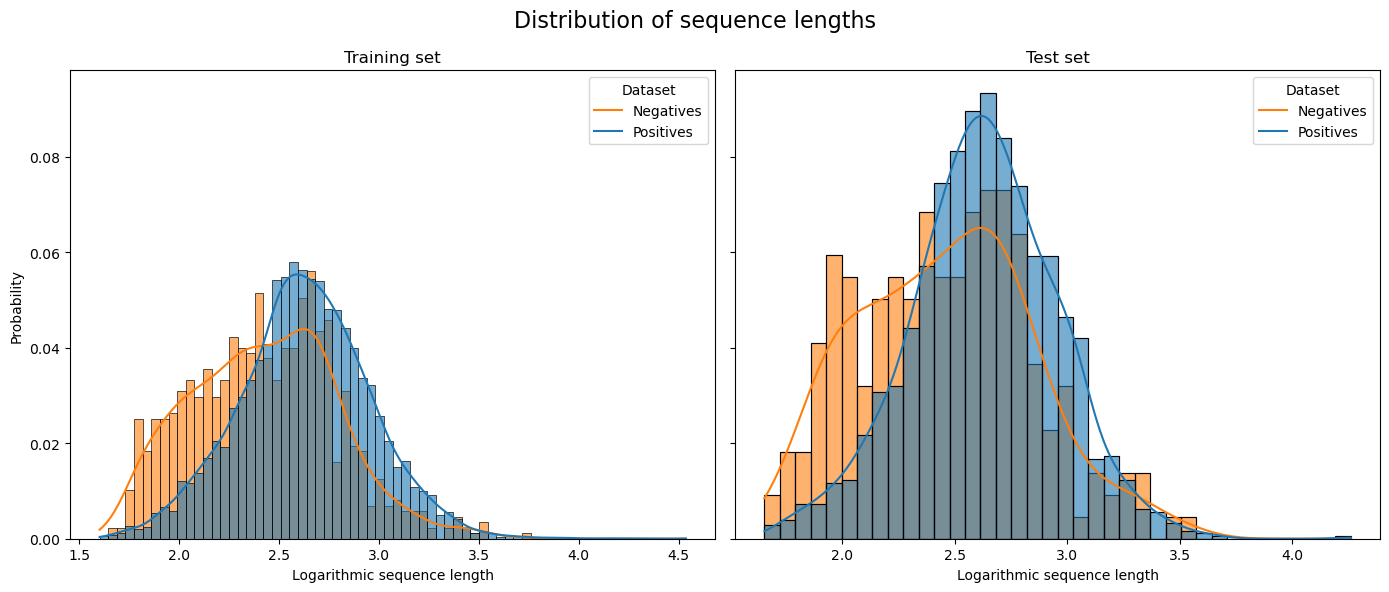

In [6]:
path_figures = "../data_analysis/figures/"
name = path_figures + 'Sequence_length_histograms.png'
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)
sns.histplot(
    data=training,
    x='log_seq_len',
    hue='sp_type',
    kde=True,
    stat='probability',
    common_norm=False,
    alpha=0.6,
    ax=axes[0]
)
axes[0].legend(title='Dataset', labels=['Negatives', 'Positives'])
axes[0].set_xlabel("Logarithmic sequence length")
axes[0].set_ylabel("Probability")
axes[0].set_title("Training set")

sns.histplot(
    data=test,
    x='log_seq_len',
    hue='sp_type',
    kde=True,
    stat='probability',
    common_norm=False,
    alpha=0.6,
    ax=axes[1]
)
axes[1].legend(title='Dataset', labels=['Negatives', 'Positives'])
axes[1].set_xlabel("Logarithmic sequence length")
axes[1].set_ylabel("Probability")
axes[1].set_title("Test set")

fig.suptitle("Distribution of sequence lengths", fontsize=16)


plt.tight_layout()
plt.savefig(name, dpi=500, format='png')
plt.show()


## **Distribution of SP lengths**

In [7]:
positive_train = training.loc[training['sp_type'] == 1]
positive_test = test.loc[test['sp_type'] == 1]

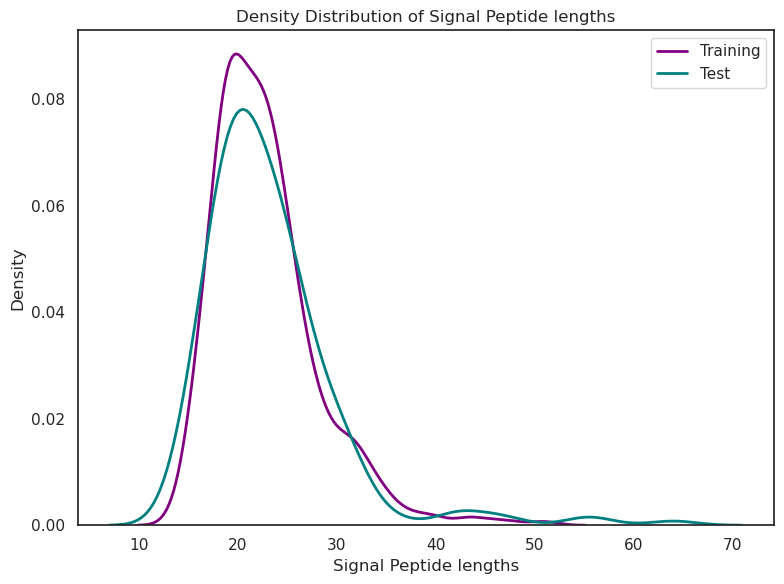

In [8]:
name_b = path_figures + 'Density_SP.png'
sns.set_theme(context='notebook',
              style='white',
              palette=['orchid', 'teal'],
              font='sans-serif',
              font_scale=1,
              color_codes=True)

plt.figure(figsize=(8,6))

sns.kdeplot(
    data=positive_train,
    x='cleavage_site',
    fill=False,
    label='Training',
    color='Purple',
    alpha=1,
    linewidth=2
)

sns.kdeplot(
    data=positive_test,
    x='cleavage_site',
    fill=False,
    label='Test',
    color='teal',
    alpha=1,
    linewidth=2
)

plt.title("Density Distribution of Signal Peptide lengths")
plt.xlabel("Signal Peptide lengths")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig(name_b, dpi=500, format='png')
plt.show()



## **Comparison of the amminoacid composition of SPs between our dataset and SwissProt data**

In [9]:
path_clusters = "../data_preparation/clusters/"
def fasta_to_dataframe(fasta_file):
  records = SeqIO.parse(fasta_file, "fasta")
  data = {
      "id": [],
      "sequence": []
  }
  for record in records:
      data["id"].append(record.id)
      data["sequence"].append(str(record.seq))
  pos_seqs = pd.DataFrame(data)
  return pos_seqs

pos_seqs = fasta_to_dataframe(path_clusters +  "cluster-results_rep_seq.fasta")

In [10]:
pos_seqs.head()

,id,sequence
0,Q16568,MESSRVRLLPLLGAALLLMLPLLGTRAQEDAELQPRALDIYSAVDD...
1,Q16627,MKISVAAIPFFLLITIALGTKTESSSRGPYHPSECCFTYTTYKIPR...
2,Q5ZPR3,MLRRRGSPGMGVHVGAALGALWFCLTGALEVQVPEDPVVALVGTDA...
3,Q6UW88,MALGVPISVYLLFNAMTALTEEAAVTVTPPITAQQGNWTVNKTEAD...
4,Q6UX27,MTAEFLSLLCLGLCLGYEDEKKNEKPPKPSLHAWPSSVVEAESNVT...


In [11]:
new_pos_train = pos_seqs.merge(positive_train[['id','cleavage_site']], how='inner')
print(new_pos_train.shape)
new_pos_test = pos_seqs.merge(positive_test[['id','cleavage_site']], how='inner')
print(new_pos_test.shape)

(874, 3)
(219, 3)


In [12]:
new_pos_train.head()

,id,sequence,cleavage_site
0,Q16568,MESSRVRLLPLLGAALLLMLPLLGTRAQEDAELQPRALDIYSAVDD...,27.0
1,Q5ZPR3,MLRRRGSPGMGVHVGAALGALWFCLTGALEVQVPEDPVVALVGTDA...,28.0
2,Q6UW88,MALGVPISVYLLFNAMTALTEEAAVTVTPPITAQQGNWTVNKTEAD...,22.0
3,Q6UX27,MTAEFLSLLCLGLCLGYEDEKKNEKPPKPSLHAWPSSVVEAESNVT...,16.0
4,Q6UXD5,MGTPRAQHPPPPQLLFLILLSCPWIQGLPLKEEEILPEPGSETPTV...,27.0


In [13]:
def cut_sp_sequence(row):
    return str(row['sequence'])[:int(row['cleavage_site'])]

def frequency_calculator(dataset):
  dataset['sp_sequence'] = dataset.apply(cut_sp_sequence, axis=1)
  all_seq = dataset['sp_sequence'].str.cat()
  all_seq = pd.Series(list(all_seq))
  all_seq = all_seq[all_seq != 'X']
  frequencies = all_seq.value_counts(normalize=True) * 100
  return frequencies

training_freq = frequency_calculator(new_pos_train)
test_freq = frequency_calculator(new_pos_test)
print(training_freq)
print(test_freq)

L    21.954156
A    14.029192
V     8.396449
S     7.593921
M     6.355018
G     5.993881
F     4.975673
I     4.529267
T     4.514220
P     4.032703
R     3.230175
C     2.889101
K     2.221999
Q     2.056478
W     1.825751
E     1.384361
H     1.133571
Y     1.023223
N     1.018207
D     0.842654
Name: proportion, dtype: float64
L    21.950739
A    15.330049
V     7.940887
S     7.290640
M     6.246305
G     6.029557
F     5.142857
I     4.532020
P     4.334975
T     4.256158
R     3.251232
C     2.896552
K     2.187192
Q     1.970443
W     1.615764
E     1.123153
H     1.044335
Y     1.004926
D     0.926108
N     0.926108
Name: proportion, dtype: float64


In [14]:
aa_freq = {
    'A': 8.25, 'Q': 3.93, 'L': 9.64, 'S': 6.65,
    'R': 5.52, 'E': 6.71, 'K': 5.79, 'T': 5.36,
    'N': 4.06, 'G': 7.07, 'M': 2.41, 'W': 1.10,
    'D': 5.46, 'H': 2.27, 'F': 3.86, 'Y': 2.92,
    'C': 1.38, 'I': 5.90, 'P': 4.74, 'V': 6.85
}
swissprot_freq = pd.Series(aa_freq)
print(swissprot_freq)


A    8.25
Q    3.93
L    9.64
S    6.65
R    5.52
E    6.71
K    5.79
T    5.36
N    4.06
G    7.07
M    2.41
W    1.10
D    5.46
H    2.27
F    3.86
Y    2.92
C    1.38
I    5.90
P    4.74
V    6.85
dtype: float64


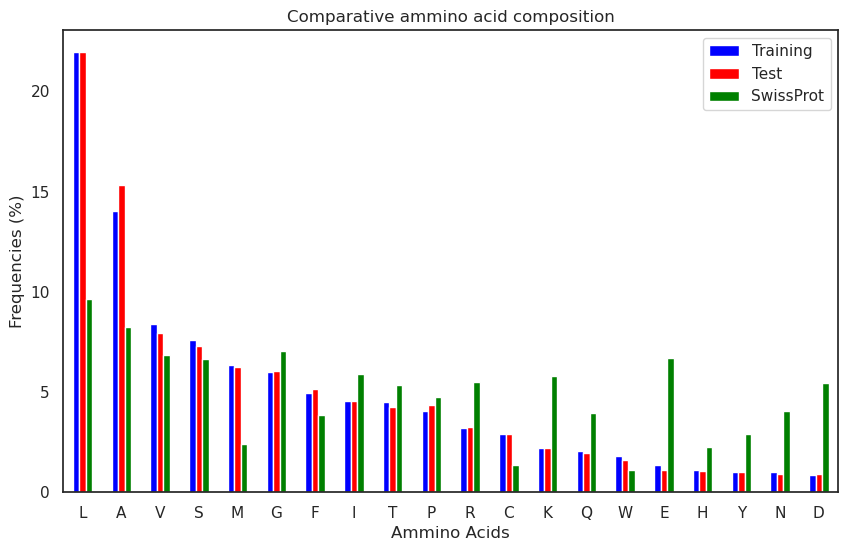

In [15]:

name_b = path_figures +  "Aminoacid_composition.png"
df = pd.concat([training_freq, test_freq, swissprot_freq], axis=1)
ax = df.plot(kind="bar", figsize=(10,6), color=['blue', 'red', 'green'])
ax.legend(['Training', 'Test','SwissProt'])
ax.set_ylabel("Frequencies (%)")
ax.set_xlabel("Ammino Acids")
ax.set_title("Comparative ammino acid composition")
plt.xticks(rotation=0)
plt.savefig(name_b, dpi=500, format='png')
plt.show()

## **Taxonomic classification at kingdom and species level**

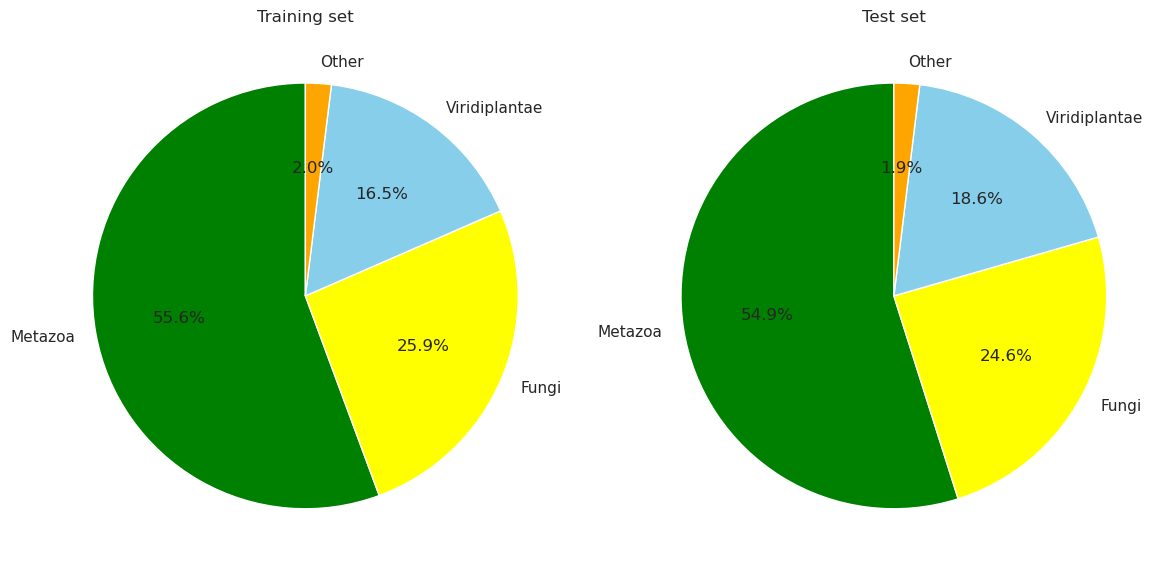

In [16]:
name_b = path_figures + 'Kingdom_pie_charts.png'
kingdom_count_train = training['kingdom'].value_counts()
kingdom_count_test = test['kingdom'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12,6))

axes[0].pie(
    kingdom_count_train,
    labels=kingdom_count_train.index,
    colors=['green', 'yellow', 'skyblue', 'orange'],
    autopct='%1.1f%%',
    startangle=90
)
axes[0].set_title("Training set")

axes[1].pie(
    kingdom_count_test,
    labels=kingdom_count_test.index,
    colors=['green', 'yellow', 'skyblue', 'orange'],
    autopct='%1.1f%%',
    startangle=90
)
axes[1].set_title("Test set")

plt.tight_layout()
plt.savefig(name_b, dpi=500, format='png')
plt.show()


In [17]:
path_sp_seq = "../data_analysis/SP_sequences/"
def cut_sp_sequence_logo(row):
  return str(row['sequence'])[(int(row['cleavage_site'])-13):(int(row['cleavage_site'])+2)]

def to_fasta(dataset, name ,path):
    output_file = f"Logo_sequence_{name}.fasta"
    with open(path + output_file, "w") as logo_seq:
        for _, row in dataset.iterrows():
            logo_seq.write(f">{row['id']}\n{row['logo_sequence']}\n")
    return logo_seq

new_pos_train['logo_sequence'] = new_pos_train.apply(cut_sp_sequence_logo, axis=1)
new_pos_test['logo_sequence'] = new_pos_test.apply(cut_sp_sequence_logo, axis=1)

to_fasta(new_pos_train, 'train', path_sp_seq)
to_fasta(new_pos_test, 'test', path_sp_seq)

<_io.TextIOWrapper name='../data_analysis/SP_sequences/Logo_sequence_test.fasta' mode='w' encoding='UTF-8'>